<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#データを読み込み、プロット" data-toc-modified-id="データを読み込み、プロット-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>データを読み込み、プロット</a></span></li><li><span><a href="#統計分析" data-toc-modified-id="統計分析-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>統計分析</a></span></li><li><span><a href="#シミュレーション" data-toc-modified-id="シミュレーション-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>シミュレーション</a></span></li><li><span><a href="#データを書き出す" data-toc-modified-id="データを書き出す-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>データを書き出す</a></span></li></ul></div>

# Jupyter+R Tutorial 2

Yoshinobu Ishizaki
2020/02/20

Tutorial1ではプロットをするところまでだったが、Rを使うなら統計分析は是非やっておきたい。

## データを読み込み、プロット

Rでデータ分析するのに、必要なライブラリを読みこむ。
tidyverse, readxlの2つで大抵は事足りる。
Excelのデータの読み書きにはopenxlsxを使っても良い（readxlは読むだけなので）。

In [93]:
library(tidyverse)
# library(readxl)
library(openxlsx) # openxlsxのみ使う

In [2]:
# おまじない。プロットの大きさが見やすいように。
options(repr.plot.width = 10, repr.plot.height = 10/16*9) # 16:9 

# 文字をちょっと大きく
theme_set(theme_grey(base_size = 16))

予めアップロードしてあるエクセルのファイルを読み込む。

In [4]:
# openxlsxの場合は.でつながったコマンド
# 勿論シート名を指定しても良い
d2  <- read.xlsx("trfh8310z2-kncl-hardness2.xlsx","Sheet1")

In [5]:
head(d2)

,no,HV,name,remark
,<dbl>,<dbl>,<chr>,<chr>
1,1,112.1,TR8310Z 枝管1,中子なし
2,1,99.4,TR8310Z 枝管1,中子なし
3,1,99.9,TR8310Z 枝管1,中子なし
4,2,103.4,TR8310Z 枝管1,中子なし
5,2,114.3,TR8310Z 枝管1,中子なし
6,2,104.1,TR8310Z 枝管1,中子なし


noが数値として認識されているので、因子化する。

In [7]:
d2$no  <-  as.factor(d2$no)

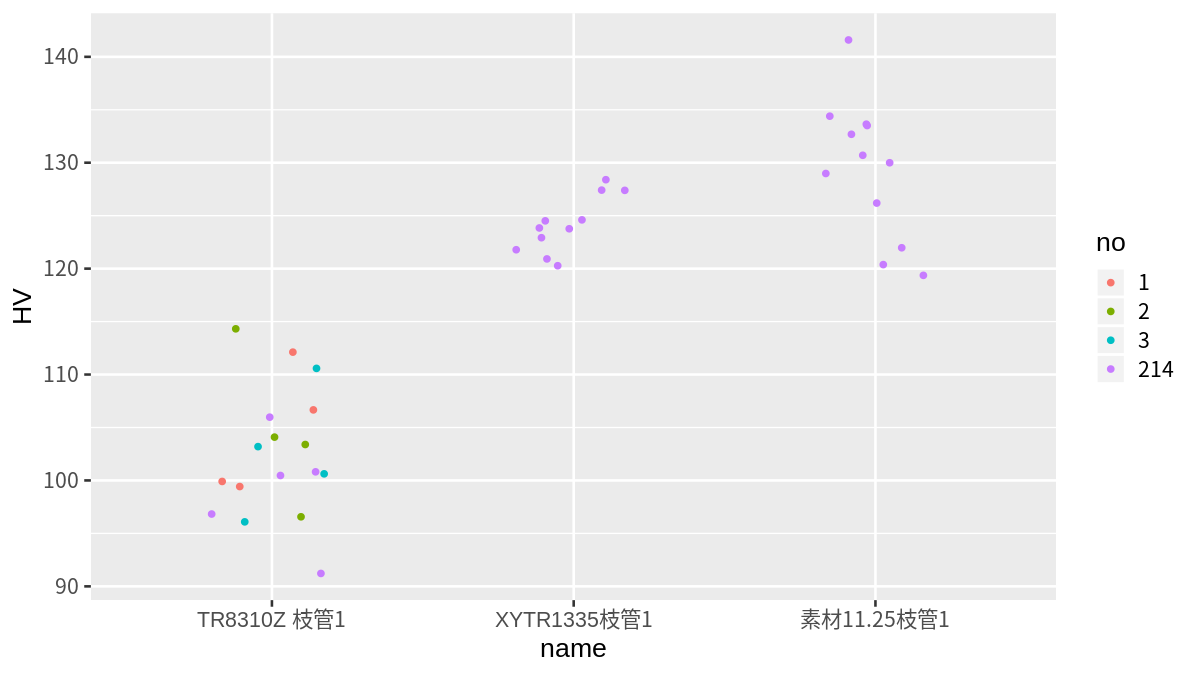

In [8]:
g1  <- ggplot(d2, aes(x = name, y = HV, color = no))
g1 + geom_jitter(width = 0.2)

## 統計分析

見た感じ部品によって硬さが違うのは明らかと思われるが、見た目の印象を述べるだけでは工学的ではない。
統計処理をして推計値を述べることで初めて客観的とみなされうる。

さらに、TR8310Z枝管1が残り2つと違うのは間違いなさそうだが、残り2つには違いが有ると言えるだろうか？

Rには分散分析のコマンドが元から組み込まれているので、簡単な式を書くだけで統計処理を実行出来る。

In [12]:
# HVはnameに依存していると言えるか？
a1  <- aov(HV ~ name, data = d2)

In [10]:
a1

Call:
   aov(formula = HV ~ name, data = d2)

Terms:
                    name Residuals
Sum of Squares  5998.604  1133.152
Deg. of Freedom        2        37

Residual standard error: 5.534052
Estimated effects may be unbalanced

In [11]:
summary(a1)

            Df Sum Sq Mean Sq F value   Pr(>F)    
name         2   5999  2999.3   97.93 1.66e-15 ***
Residuals   37   1133    30.6                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

判定が`***`となるので、HVがnameに依存していないという仮定は危険率0.001の元でも棄却される。

ぶっちゃけ、nameが違えばHVが違うといって良い。見た目の印象は裏付けられた。

ざっとそれぞれのグループごとに平均値や標準偏差を確認してみる。

In [14]:
d2  %>% group_by(name) %>% summarise(mean(HV),sd(HV))

name,mean(HV),sd(HV)
<chr>,<dbl>,<dbl>
TR8310Z 枝管1,102.4882,6.090862
XYTR1335枝管1,124.1636,2.687479
素材11.25枝管1,129.4583,6.518151


TR8310Z 枝管1以外の2つにはどの程度の差があるのか。

その部分だけ取り出して今度はT検定をやってみる。

In [15]:
d3  <- d2 %>% filter(name != 'TR8310Z 枝管1')

In [19]:
a2  <- t.test(HV~name, data=d3)

In [20]:
a2


	Welch Two Sample t-test

data:  HV by name
t = -2.5844, df = 14.895, p-value = 0.02082
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.6640591 -0.9253348
sample estimates:
 mean in group XYTR1335枝管1 mean in group 素材11.25枝管1 
                    124.1636                     129.4583 


一応、平均値が違うのは2%ぐらいの危険率で棄却。
つまり、これら2種類も違う集団と判定される。

In [22]:
summary(aov(HV~name, data = d3))

            Df Sum Sq Mean Sq F value Pr(>F)  
name         1  160.9  160.89   6.262 0.0207 *
Residuals   21  539.6   25.69                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

分散分析しても当然同様の結果が得られる。

大抵の統計分析はデータが正規分布していることを前提にしている。

なので、正規分布してない集団に統計処理をしてもあまり意味がない(Cpkも)。

ここでは順番が逆になるが、ある集団のデータの正規性を確認する。

In [24]:
d_1125  <- d2 %>% filter(name == '素材11.25枝管1')

手軽なチェック法としてQQプロットを見る。点が直線に概ね乗っていれば概ね正規的と言える。

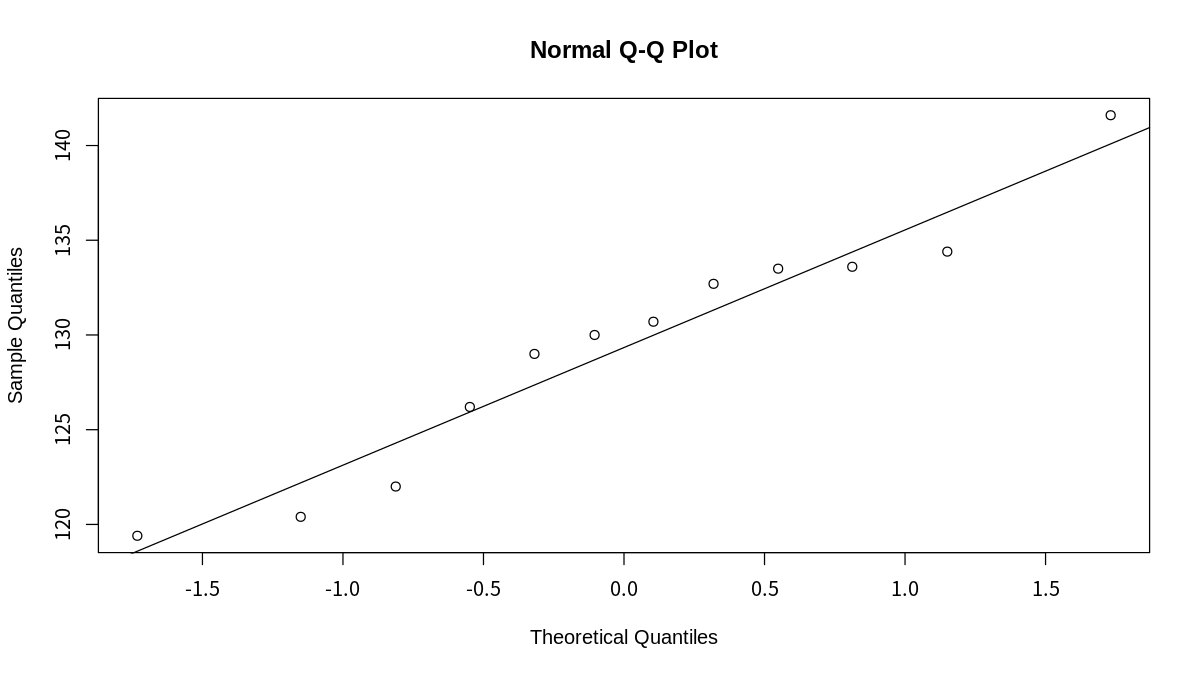

In [28]:
qqnorm(d_1125$HV)
qqline(d_1125$HV)

印象でなく確率計算するなら、正規性検定を行う。
Shapiro-Wilkの検定で棄却されなければ、正規性の仮定は実質認めても良い。

In [30]:
shapiro.test(d_1125$HV)


	Shapiro-Wilk normality test

data:  d_1125$HV
W = 0.94836, p-value = 0.6131


p < 0.05だと棄却するレベルだが、どうやら大丈夫らしい。

## シミュレーション

様々な仮定に基づくことになるが、得られたデータを元にシミュレーションすることで、将来の予測をある程度行うことが出来る。

例えば、素材11.25の硬さとして、今回データの平均と標準偏差を使って正規分布を仮定して計算してみる。

- 正規分布していること
- 平均値が今回の平均値に等しいこと
- 標準偏差が今回の標準偏差に等しいこと
- 分布が将来も変わらないこと

を仮定してることになり、実際にはそのどれも起こり得ないので、かなり雑な予測でしか無い(Cpk判定も同様)。

実際のデータから平均と標準偏差を取り出して、

In [59]:
m1 = mean(d_1125$HV)
s1 = sd(d_1125$HV)

適当な個数（ここでは10,000個）のランダムデータを作る。

シミュレーションをする際は、ランダムの種を固定しておくと再現性を担保出来る。

In [75]:
set.seed(1125)

In [76]:
sim1  <- data.frame( no = NA, HV = rnorm(1e4, mean = m1, sd = s1), name = "SIM", remark = NA)

In [77]:
head(sim1)

,no,HV,name,remark
,<lgl>,<dbl>,<fct>,<lgl>
1,NA,128.8928,SIM,NA
2,NA,133.5637,SIM,NA
3,NA,120.5341,SIM,NA
4,NA,136.4010,SIM,NA
5,NA,127.7328,SIM,NA
6,NA,132.8013,SIM,NA


元のデータと合体させて、ヒストグラムを比較してみる。

In [78]:
d4 = rbind(d_1125,sim1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



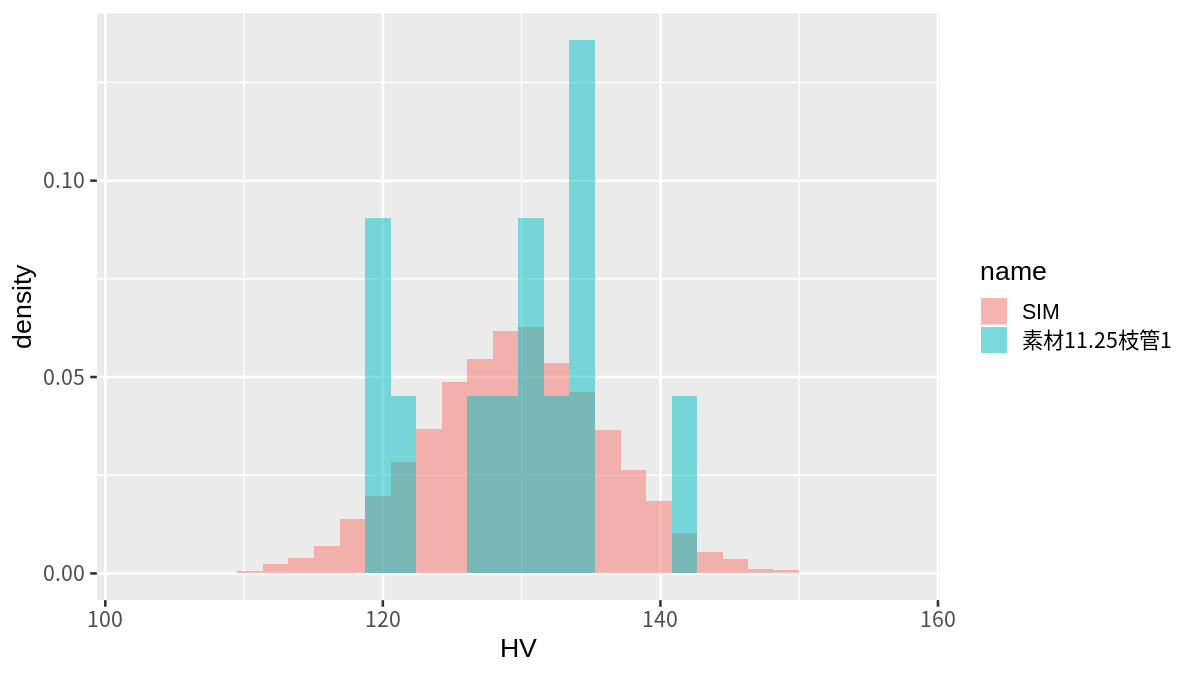

In [79]:
g2  <- ggplot(d4, aes(x = HV, y = ..density.. , fill= name))
g2 + geom_histogram(alpha = 0.5, position = 'identity')

In [80]:
d4  %>% group_by(name) %>% summarise(mean(HV),sd(HV))

name,mean(HV),sd(HV)
<chr>,<dbl>,<dbl>
SIM,129.5207,6.529034
素材11.25枝管1,129.4583,6.518151


シミュレーションしたので当然だが、平均と標準偏差はほぼ一致する。

仮に110HVが限界値でこれを下回るのは不良とすると、1万個中の発生数量は、

In [89]:
sum(sim1$HV < 110)

[1] 7

個となる。

この数字が許容できるかどうかは、発生した不良による損失がどの程度かによって決めるべきもの。

1個300円で、不良が発生しても現場で廃棄するだけのものなら、損失額は

In [91]:
paste(7*300,"円")

[1] "2100 円"

最悪顧客に流出し、それによる不具合の対応で20万/件と見込まれるなら損失額は、

In [92]:
paste(7*200e3,"円")

[1] "1400000 円"

あらゆる工程の立ち上げで、このようにして年間見込まれる損失を計算して、その上で対応の内容を決めるべき。

何も対応しない、というのも合理的な判断としてはあり得る。

## データを書き出す

整形したりシミュレーションしたりしたデータを将来も活用するなら、保存しておいた方が良い。

In [96]:
getwd()

[1] "/home/kinzokukakou/jupyter/ishizaki/jupyter-r-tutorial"

In [99]:
write.xlsx(list(sim1), "./simulation.xlsx", row.names = FALSE)

このノートブックと同じフォルダにsimulation.xlsxができてるはずなので、フォルダリストの画面からダウンロードすると良い。

In [100]:
list.files()

[1] "sample.PNG"                     "simulation.xlsx"               
[3] "sl825-tube-outerdia.xlsx"       "trfh8310z2-kncl-hardness2.xlsx"
[5] "tutorial1.ipynb"                "tutorial2.ipynb"